In [1]:
import pandas as pd
import numpy as np
import pcg_skel
import tqdm
from meshparty import meshwork
from caveclient import CAVEclient
import datetime
import os

client = CAVEclient('minnie65_phase3_v1')

In [2]:
now = client.materialize.get_timestamp()

In [3]:
skeldir = 'skeletons'

In [4]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### EXTENDED FIGURE 4

# Plot for Basket Cells (proximal targeting cells)

In [5]:
# Get synapses formed by the axons of comprehensively extended ET neurons
ET_synapse_table = pd.read_feather("ET_extended_synapse_table.feather")

# Sort postsynaptic basket cells based on the number of synapses that it
# receives from the extended ET neurons
# ----------------------------------------------------------------------

values = []

#root IDs of postynaptic BC neurons
pre_soma_IDs = ET_synapse_table.query('consensus_subclass == "BC"').post_pt_root_id.unique().tolist()


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
   
    stat_values={

                    'ID': pre_soma_ID,
                    'syn_from_ET': len(ET_synapse_table[ (ET_synapse_table['post_pt_root_id'] == pre_soma_ID)]),
             
        
        
    }
    values.append(stat_values)
    
    

synapse_table_BC_values = pd.DataFrame(values)

synapse_table_BC_values_sorted  = synapse_table_BC_values.sort_values(by='syn_from_ET', ascending=False)


In [6]:
# Build the skeletons of the BC neurons

inhibitory_targets_df = synapse_table_BC_values_sorted.head(25) 
print(inhibitory_targets_df)

nrns = {}

for _, row in tqdm.tqdm(inhibitory_targets_df.iterrows()):

    print(row["ID"])
    if os.path.exists(f"{skeldir}/{row['ID']}.h5"):
        nrns[row["ID"]] = meshwork.load_meshwork(f"{skeldir}/{row['ID']}.h5")
   
    else:
    
        nrns[row["ID"]] = pcg_skel.coord_space_meshwork(
            row["ID"],
            client=client,
            root_point= ET_synapse_table[ET_synapse_table['post_pt_root_id'] == row["ID"]].post_soma_pt.iloc[0],#row["pt_position"], post_soma_pt
            root_point_resolution=[4, 4, 40],
            collapse_soma=True,
            synapses="all",
            synapse_table=client.info.get_datastack_info().get("synapse_table"),
            timestamp = now,
        )

        nrns[row["ID"]].save_meshwork(f"{skeldir}/{row['ID']}.h5")        
        
# Get the axons
for rid, nrn in nrns.items():
    is_axon = meshwork.algorithms.split_axon_by_annotation(
        nrn,
        'pre_syn',
        'post_syn',
        return_quality=False
    )
    nrn.anno.add_annotations('is_axon', is_axon, mask=True)

                     ID  syn_from_ET
30   864691135066377796           31
90   864691136092188340           27
214  864691135697251482           27
153  864691136021587704           25
81   864691135837584531           21
244  864691136021592568           21
64   864691135938746933           21
63   864691135594101291           18
82   864691135772832587           18
89   864691135865167998           16
215  864691135865971164           16
9    864691136024968505           15
27   864691135386608213           15
209  864691135860028520           14
73   864691135772785915           14
115  864691136109199800           14
116  864691136056871128           14
196  864691135874731406           12
26   864691136032031675           12
7    864691136966961614           12
83   864691135361287751           12
39   864691136175460102           12
20   864691135360007512           12
15   864691135885129328           11
188  864691135463586973           11


0it [00:00, ?it/s]

864691135066377796


1it [00:27, 27.80s/it]

864691136092188340


2it [00:59, 30.26s/it]

864691135697251482


3it [01:26, 28.67s/it]

864691136021587704


4it [01:59, 30.24s/it]

864691135837584531


5it [02:24, 28.50s/it]

864691136021592568


6it [03:10, 34.30s/it]

864691135938746933


7it [03:34, 31.08s/it]

864691135594101291


8it [04:01, 29.66s/it]

864691135772832587


9it [04:23, 27.23s/it]

864691135865167998


10it [04:46, 26.14s/it]

864691135865971164


11it [05:16, 27.26s/it]

864691136024968505


12it [05:35, 24.85s/it]

864691135386608213


13it [05:55, 23.25s/it]

864691135860028520


14it [06:30, 26.93s/it]

864691135772785915


15it [06:57, 26.79s/it]

864691136109199800


16it [07:21, 25.98s/it]

864691136056871128


17it [07:47, 25.89s/it]

864691135874731406


18it [08:08, 24.38s/it]

864691136032031675


19it [08:29, 23.43s/it]

864691136966961614


20it [09:02, 26.41s/it]

864691135361287751


21it [09:23, 24.87s/it]

864691136175460102


22it [09:58, 27.87s/it]

864691135360007512


23it [10:21, 26.23s/it]

864691135885129328


24it [10:47, 26.21s/it]

864691135463586973


25it [11:14, 26.99s/it]


In [7]:
#Filter for presynaptic outputs on target cell axons and concatenate into one dataframe, adding synapse distance:

pre_dfs = []
for rid in inhibitory_targets_df["ID"]:
    syn_filt = nrns[rid].anno.pre_syn.filter_query(
            nrns[rid].anno.is_axon.mesh_mask
    )
    df = syn_filt.df
    df['dist_to_root'] = nrns[rid].distance_to_root(syn_filt.mesh_index)
    df['distance_rank'] = df['dist_to_root'].rank()
    df.attrs = {}
    pre_dfs.append(df)

inhibitory_targets_pre_df= pd.concat(pre_dfs, ignore_index=True)
inhibitory_targets_pre_df['pre_pt_root_id'] = client.chunkedgraph.get_roots(inhibitory_targets_pre_df['pre_pt_supervoxel_id'], timestamp=now)
inhibitory_targets_pre_df['post_pt_root_id'] = client.chunkedgraph.get_roots(inhibitory_targets_pre_df['post_pt_supervoxel_id'], timestamp=now).astype('int')


In [8]:
# Get single soma root ids and add cell types

soma_df = client.materialize.query_table(
    "nucleus_neuron_svm", filter_equal_dict={"cell_type": "neuron"}
)

soma_df = soma_df.drop_duplicates(subset="pt_root_id", keep='first')

mtypes_model_df = client.materialize.query_table(
    "aibs_metamodel_mtypes_v661_v2",
).drop_duplicates('pt_root_id', keep=False)

# Enrich soma_df with all this info
soma_df = (
    soma_df.merge(        
        mtypes_model_df[["pt_root_id", "cell_type"]].rename(
            columns={"cell_type": "model_cell_type"}
        ),
        on="pt_root_id",
        how="left",
    )
)


#Add subclass labels to soma_df
def standardize_subclass(row):
        
        
    if row['model_cell_type'] == 'L3b':
          return 'L23-P'

    if row['model_cell_type'] == 'MC':
          return 'DTC'
    
    if row['model_cell_type'] == 'BC':
          return 'PTC'
    
    if row['model_cell_type'] == 'BPC':
          return 'ITC'
    
    if row['model_cell_type'] == 'NGC':
          return 'STC'
            
    if row['model_cell_type'] == '23P':
          return 'L23-P'
            
    if row['model_cell_type'] == 'L2b':
          return 'L23-P'
          
    if row['model_cell_type'] == 'L6tall-c':
          return 'L6-P'
          
    if row['model_cell_type'] == 'L6short-b':
          return 'L6-P'
          
    if row['model_cell_type'] == 'L4b':
          return 'L4-P'
          
    if row['model_cell_type'] == 'L2a':
          return 'L23-P'
   
    if row['model_cell_type'] == 'L3a':
          return 'L23-P'
          
    if row['model_cell_type'] == 'L6tall-b':
          return 'L6-P'
          
    if row['model_cell_type'] == 'L2c':
          return 'L23-P'
          
    if row['model_cell_type'] == 'L4a':
          return 'L4-P'

    if row['model_cell_type'] == '4P':
          return 'L4-P'
        
    if row['model_cell_type'] == 'L6wm':
          return 'L6-P'
        
    if row['model_cell_type'] == 'L6tall-a':
          return 'L6-P'
 
    if row['model_cell_type'] == 'L6short-a':
          return 'L6-P'
          
    if row['model_cell_type'] == 'L5a':
          return 'L5-IT'
        
    if row['model_cell_type'] == 'L5b':
          return 'L5-IT'
        
    if row['model_cell_type'] == 'L5ET':
          return 'L5-ET'

    if row['model_cell_type'] == 'L5NP':
          return 'L5-NP'
  
    if row['model_cell_type'] == 'L4c':
          return 'L4-P'
        
    if row['model_cell_type'] == 'none':
          return None
               
    if pd.isna(row['model_cell_type']) == True:
          return None
        
    else:
          return row['model_cell_type'] 

soma_df['model_subclass'] = soma_df.apply(standardize_subclass, axis=1)


#Merge all this info from cell types into the synapse dataframe, as well as add area locations.

#merge presynaptic nucleous ID
synapse_table = inhibitory_targets_pre_df.merge(
    soma_df[
        ["id", "pt_root_id", "pt_position", "model_subclass"]
    ].rename(columns={"pt_position": "post_soma_pt"}).rename(columns={"id": "post_nucleus_id"}),
    left_on="post_pt_root_id",
    right_on="pt_root_id",
    how="left",
).drop(columns="pt_root_id")

synapse_table = synapse_table.rename(columns={"id": "synapse_id"})

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


In [14]:
values = []

#root IDs of presynaptic PT neurons
pre_soma_IDs = inhibitory_targets_df.ID.tolist()


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
    #print(pre_soma_ID)
    stat_values={

                    'ID': pre_soma_ID,
                            
                    #SYNAPSES
        
                    
                    'all_total_syn#': len(synapse_table[ (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
        
                    'all_total_syn#_with_prediction': len(synapse_table[synapse_table['pre_pt_root_id'] == pre_soma_ID]
                                                          ['model_subclass'].dropna()), 
                    
                    'all_total_L5_targets_syn#': len(synapse_table[ ((synapse_table['model_subclass'] == 'L5-ET') |
                                                    (synapse_table['model_subclass'] == 'L5-IT') |
                                                    (synapse_table['model_subclass'] == 'L5-NP')) &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
        
                     
                    'L5-ET_syn#': len(synapse_table[ (synapse_table['model_subclass'] == 'L5-ET') &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
        
                    
                    'fraction_syn_L5-ET': len(synapse_table[ (synapse_table['model_subclass'] == 'L5-ET') &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]) /
                                            len(synapse_table[synapse_table['pre_pt_root_id'] == pre_soma_ID]
                                                          ['model_subclass'].dropna()),
        
                    'fraction_syn_L5-ET_from_L5': len(synapse_table[ (synapse_table['model_subclass'] == 'L5-ET') &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]) /
                                            len(synapse_table[ ((synapse_table['model_subclass'] == 'L5-ET') |
                                                    (synapse_table['model_subclass'] == 'L5-IT') |
                                                    (synapse_table['model_subclass'] == 'L5-NP')) &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
               
                    'fraction_syn_L5-ET_from_Exc': len(synapse_table[ (synapse_table['model_subclass'] == 'L5-ET') &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]) /
                                            len(synapse_table[ ((synapse_table['model_subclass'] == 'L5-ET') |
                                                    (synapse_table['model_subclass'] == 'L5-IT') |
                                                    (synapse_table['model_subclass'] == 'L5-NP')|
                                                    (synapse_table['model_subclass'] == 'L23-P')|
                                                    (synapse_table['model_subclass'] == 'L4-P')|
                                                    (synapse_table['model_subclass'] == 'L6-P'))&
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
        
                   

        
        
    }
    values.append(stat_values)
    
    

synapse_area_table_values = pd.DataFrame(values)

synapse_area_table_values

864691135066377796
864691136092188340
864691135697251482
864691136021587704
864691135837584531
864691136021592568
864691135938746933
864691135594101291
864691135772832587
864691135865167998
864691135865971164
864691136024968505
864691135386608213
864691135860028520
864691135772785915
864691136109199800
864691136056871128
864691135874731406
864691136032031675
864691136966961614
864691135361287751
864691136175460102
864691135360007512
864691135885129328
864691135463586973


,ID,all_total_syn#,all_total_syn#_with_prediction,all_total_L5_targets_syn#,L5-ET_syn#,fraction_syn_L5-ET,fraction_syn_L5-ET_from_L5,fraction_syn_L5-ET_from_Exc
0,864691135066377796,1829,1594,1122,861,0.540151,0.767380,0.674236
1,864691136092188340,2591,2269,1542,1154,0.508594,0.748379,0.629569
2,864691135697251482,2244,2068,1440,1079,0.521760,0.749306,0.648048
3,864691136021587704,2404,2245,1751,1420,0.632517,0.810965,0.739583
4,864691135837584531,1654,1530,1235,993,0.649020,0.804049,0.753986
5,864691136021592568,7013,6093,4027,1855,0.304448,0.460641,0.371223
6,864691135938746933,1872,1682,1237,1091,0.648633,0.881973,0.782079
7,864691135594101291,2066,1842,1242,1034,0.561346,0.832528,0.724090
8,864691135772832587,1785,1658,1121,977,0.589264,0.871543,0.804115
9,864691135865167998,2161,1997,1450,1152,0.576865,0.794483,0.693558


In [20]:
synapse_table.head()

,synapse_id,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_mesh_ind_filt,dist_to_root,distance_rank,post_nucleus_id,post_soma_pt,model_subclass
0,469950567,11152,114508364134004964,864691135066377796,114508364134002735,864691135274709989,"[361952, 198022, 19217]","[361980, 198114, 19222]","[361996, 198079, 19220]",186565958171623978,10351,10351,457581.773148,1829.0,619705.0,"[360432, 196240, 19528]",L5-ET
1,449906518,6028,112748665298856694,864691135066377796,112748665365381714,864691135122798375,"[348900, 194410, 25600]","[348972, 194410, 25608]","[348873, 194421, 25607]",184806259336151913,8227,8227,232668.527740,633.0,669907.0,"[364832, 197232, 25542]",L5-ET
2,415703342,8176,109864233646241673,864691135066377796,109934602390434316,864691135926846478,"[328158, 199858, 22569]","[328274, 199866, 22584]","[328257, 199851, 22576]",181921827684089991,3900,3900,234341.332489,656.0,589250.0,"[337184, 191568, 22863]",L5-ET
3,469950181,13736,114438064109383080,864691135066377796,114438064109390350,864691135274709989,"[361468, 198428, 19268]","[361436, 198442, 19276]","[361512, 198315, 19265]",186495658146923144,10266,10266,454414.288284,1826.5,619705.0,"[360432, 196240, 19528]",L5-ET
4,394738166,2728,108245821518356151,864691135066377796,108245821518362358,864691135697234842,"[315970, 200196, 24885]","[315994, 200304, 24892]","[315992, 200272, 24888]",180303415555916409,2058,2058,222946.451828,475.0,531378.0,"[306032, 196048, 25567]",L6-P


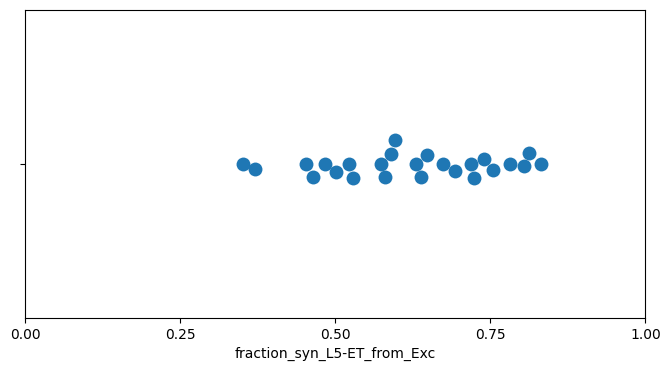

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8,4))

ax = sns.swarmplot(data=synapse_area_table_values, x="fraction_syn_L5-ET_from_Exc", size=10)

ax.set(xlim=(0, 1))
ax.set_xticks([0,0.25,0.5,0.75,1])

plt.savefig('Extended_4.eps')